In [1]:
import gspread
from oauth2client.service_account import ServiceAccountCredentials
from gspread_formatting import *

from collections import Counter
import numpy as np
import time
import pandas as pd

import datetime as dt

import matplotlib
import matplotlib.pyplot as plt
import matplotlib.patheffects as path_effects
from matplotlib import ticker
from matplotlib.ticker import MaxNLocator

from matplotlib.gridspec import GridSpec
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
import itertools as it

plt.rcParams['figure.facecolor'] = 'white'
plt.rcParams['axes.facecolor']='white'
plt.rcParams['savefig.facecolor']='white'
plt.rc('axes', axisbelow=True)
%matplotlib inline

In [2]:
# use creds to create a client to interact with the Google Drive API
scope = ['https://spreadsheets.google.com/feeds',
         'https://www.googleapis.com/auth/drive']

creds = ServiceAccountCredentials.from_json_keyfile_name('../client_secret.json', scope)
client = gspread.authorize(creds)

In [3]:
dates_tt = ['2020-09-01','2020-10-01','2020-11-01','2020-12-01','2021-01-01','2021-02-01',
            '2021-03-01','2021-04-01','2021-05-01']
dates_ll = ['Sep','Oct','Nov','Dec','2021','Feb','Mar','Apr','May']
wid = 4
barw = 4.5
nw = 4

In [57]:
outbreak_data = client.open("COVID-data_OutbreakSettings")
outbreak_labs = outbreak_data.worksheet('setting_map')
outbreak_labs = pd.DataFrame(outbreak_labs.get_all_records(default_blank=np.nan))
outbreak_labs = outbreak_labs[['source','setting_raw','setting','setting_abbrev']].copy()

labs = dict(zip(outbreak_labs['setting'].values,outbreak_labs['setting_abbrev'].values))

In [5]:
today = time.strftime("%Y-%m-%d")

month_dict = {'01':'Jan','02':'Feb','03':'Mar','04':'Apr','05':'May','06':'Jun',
              '07':'Jul','08':'Aug','09':'Sep','10':'Oct','11':'Nov','12':'Dec'}

weekday_mapping = {0:'Monday',1:'Tuesday',2:'Wednesday',3:'Thursday',4:'Friday',5:'Saturday',6:'Sunday'}

alldates = pd.date_range(start='2020-01-06', end='2021-12-31').tolist()
datelist = [str(i.date()) for i in alldates]
weekdays = [weekday_mapping[i.date().weekday()] for i in alldates]
weeklist = [i//7 for i in range(len(alldates))]
DATE_DF = pd.DataFrame({'date':datelist,'day':weekdays,'week':weeklist})
DATERANGE = DATE_DF['date'].tolist()

date_dict = {DATERANGE[i]:i for i in range(len(DATERANGE))}

In [6]:
import json
import urllib.request

def get_ci(df, col, gb_col='date', percentile='95'):
    if percentile == '999':
        cival = 3.291
    if percentile == '995':
        cival = 2.807
    if percentile == '99':
        cival = 2.576
    if percentile == '95':
        cival = 1.96
    if percentile == '90':
        cival = 1.645
    if percentile == '80':
        cival = 1.282

    df_stats = df.groupby(gb_col)[col].agg([np.nanmean,'count',np.nanstd])
    ci95_hi = []
    ci95_lo = []
    for i in df_stats.index:
        m, c, s = df_stats.loc[i]
        ci95_hi.append(m + cival*s/np.sqrt(c))
        ci95_lo.append(m - cival*s/np.sqrt(c))
    df_stats['ci95_hi'] = ci95_hi
    df_stats['ci95_lo'] = ci95_lo

    return df_stats.reset_index()

all_state_names = {'ak': 'Alaska', 'al': 'Alabama', 'ar': 'Arkansas',
                   'as': 'American Samoa',  'az': 'Arizona',
                   'ca': 'California', 'co': 'Colorado',
                   'ct': 'Connecticut', 'dc': 'District of Columbia',
                   'de': 'Delaware', 'fl': 'Florida', 'ga': 'Georgia',
                   'gu': 'Guam', 'hi': 'Hawaii', 'ia': 'Iowa',
                   'id': 'Idaho', 'il': 'Illinois', 'in': 'Indiana',
                   'ks': 'Kansas', 'ky': 'Kentucky', 'la': 'Louisiana',
                   'ma': 'Massachusetts', 'md': 'Maryland', 'me': 'Maine',
                   'mi': 'Michigan', 'mn': 'Minnesota', 'mo': 'Missouri',
                   'mp': 'Northern Mariana Islands', 'ms': 'Mississippi',
                   'mt': 'Montana', 'nc': 'North Carolina',
                   'nd': 'North Dakota', 'ne': 'Nebraska',
                   'nh': 'New Hampshire', 'nj': 'New Jersey',
                   'nm': 'New Mexico', 'nv': 'Nevada', 'ny': 'New York',
                   'oh': 'Ohio', 'ok': 'Oklahoma', 'or': 'Oregon',
                   'pa': 'Pennsylvania', 'pr': 'Puerto Rico',
                   'ri': 'Rhode Island', 'sc': 'South Carolina',
                   'sd': 'South Dakota', 'tn': 'Tennessee', 'tx': 'Texas',
                   'ut': 'Utah', 'va': 'Virginia',
                   'vi': 'Virgin Islands', 'vt': 'Vermont',
                   'wa': 'Washington', 'wi': 'Wisconsin',
                   'wv': 'West Virginia', 'wy': 'Wyoming'}

all_state_ids = {'01': 'al', '02': 'ak', '04': 'az', '05': 'ar',
                 '06': 'ca', '08': 'co', '09': 'ct', '10': 'de',
                 '11': 'dc', '12': 'fl', '13': 'ga', '15': 'hi',
                 '16': 'id', '17': 'il', '18': 'in', '19': 'ia',
                 '20': 'ks', '21': 'ky', '22': 'la', '23': 'me',
                 '24': 'md', '25': 'ma', '26': 'mi', '27': 'mn',
                 '28': 'ms', '29': 'mo', '30': 'mt', '31': 'ne',
                 '32': 'nv', '33': 'nh', '34': 'nj', '35': 'nm',
                 '36': 'ny', '37': 'nc', '38': 'nd', '39': 'oh',
                 '40': 'ok', '41': 'or', '42': 'pa', '44': 'ri',
                 '45': 'sc', '46': 'sd', '47': 'tn', '48': 'tx',
                 '49': 'ut', '50': 'vt', '51': 'va', '53': 'wa',
                 '54': 'wv', '55': 'wi', '56': 'wy', "60": 'as',
                 "66": 'gu', "72": 'pr', '78': 'vi', '69': 'mp'}

all_ids_state = {j:i for i,j in all_state_ids.items()}
all_names_state = {j:i for i,j in all_state_names.items()}


jhu_url = 'https://coronavirus.jhu.edu/datasets/state_timeline.json'
with urllib.request.urlopen(jhu_url) as url_i:
    data_i = json.loads(url_i.read().decode())

state_pop = pd.read_csv('https://raw.githubusercontent.com/'+\
                        'CivilServiceUSA/us-states/master/data/states.csv')
state_pop = state_pop[['state','population']].copy()
extra_states = ['District of Columbia','United States','Puerto Rico','Virgin Islands',
                'Guam','Northern Mariana Islands']
extra_populs = [692683,330854067,3193694,106631,167294,57216]
state_pop = pd.concat([state_pop,
                       pd.DataFrame({'state':extra_states,
                             'population':extra_populs})]).reset_index().iloc[:,1:]

sdate = min([i['values']['new-confirmed-cases'][0]['dt'] for i in data_i.values()])
ldate = max([i['values']['new-confirmed-cases'][0]['dt'] for i in data_i.values()])

ll_out = []
for st in data_i.keys():
    st_df_cases = pd.DataFrame(data_i[st]['values']['new-confirmed-cases'])
    st_df_cases.columns = ['date','new_cases_7day_avg','new_cases','cases']
    st_df_deaths = pd.DataFrame(data_i[st]['values']['new-deaths'])
    st_df_deaths.columns = ['date','new_deaths_7day_avg','new_deaths','deaths']
    st_df = st_df_cases.merge(st_df_deaths, how='left', on='date')

    ev_out = []
    for i in [i for i in data_i[st]['events']]:
        for ix in i['values']:
            ix['date'] = i['dt']
            ev_out.append(ix)

    st_df_events = pd.DataFrame(ev_out)
    st_df_events.columns = ['event_type','event_description','date']

    st_df = st_df.merge(st_df_events, how='left', on='date')
    st_df['state'] = st
    st_df['fips'] = all_ids_state[all_names_state[st]]
    st_df['population'] = state_pop.loc[state_pop['state']==st]['population'].values[0]
    st_df['new_cases'] = st_df['new_cases_7day_avg']
    st_df['new_deaths'] = st_df['new_deaths_7day_avg']
    st_df['new_cases_per_1000'] = st_df['new_cases'] / st_df['population'] * 1000
    st_df['new_deaths_per_1000'] = st_df['new_deaths'] / st_df['population'] * 1000
    st_df['cases_per_1000'] = st_df['cases'] / st_df['population'] * 1000
    st_df['deaths_per_1000'] = st_df['deaths'] / st_df['population'] * 1000
    st_df = DATE_DF.loc[(DATE_DF['date']>=sdate)][['date']].merge(st_df, how='left', on='date')
    ll_out.append(st_df)


llx = pd.concat(ll_out)
ll = llx[['date', 'state', 'fips', 'cases', 'deaths', 'population', 'new_cases',
       'new_deaths', 'new_cases_per_1000', 'new_deaths_per_1000',
       'cases_per_1000', 'deaths_per_1000']]

gbcol = ['cases', 'deaths', 'population', 'new_cases', 'new_deaths']
st_df = ll.groupby('date').agg({i:'sum' for i in gbcol}).reset_index()
st_df['new_cases_per_1000'] = st_df['new_cases'] / st_df['population'] * 1000
st_df['new_deaths_per_1000'] = st_df['new_deaths'] / st_df['population'] * 1000
st_df['cases_per_1000'] = st_df['cases'] / st_df['population'] * 1000
st_df['deaths_per_1000'] = st_df['deaths'] / st_df['population'] * 1000
st_df['state'] = 'United States'
st_df['fips'] = '00'
ll = pd.concat([ll,st_df]).sort_values(['fips','date']).reset_index().iloc[:,1:]
ll = ll.loc[~ll['state'].isna()].copy()
ll = ll.drop_duplicates().reset_index().iloc[:,1:]
ll = ll.merge(DATE_DF[['date','week']], how='left', on='date')

# Colorado

In [7]:
st_name = 'Colorado'
co_data = client.open("COVID-data_%s"%st_name)
co_df = co_data.worksheet('outbreaks')
co_df = pd.DataFrame(co_df.get_all_records(default_blank=np.nan))
co_df = co_df.rename(columns={'setting':'setting_raw'})
co_df = co_df.merge(outbreak_labs.loc[(outbreak_labs['setting_raw'].isin(co_df['setting_raw'].unique()))&\
                   (outbreak_labs['source']==st_name)])
co_df['new_cases'] = co_df['new_cases'].astype(float)
co_df['new_deaths'] = co_df['new_deaths'].astype(float)
co_df = co_df.merge(DATE_DF[['date','week']], how='left', on='date')

In [8]:
co_dfg = co_df.groupby(['setting','week']).agg({'new_cases':'sum',
                                                'new_deaths':'sum',
                                                'new_cases_employee':'sum',
                                                'new_cases_resident':'sum',
                                                'new_cases_employee':'sum',
                                                'new_cases_attendee':'sum',
                                                'new_deaths_resident':'sum',
                                                'new_deaths_employee':'sum',
                                                'new_deaths_attendee':'sum'}).reset_index()

co_out = []
for st in co_dfg['setting'].unique():
    co_dfg_s = co_dfg.loc[co_dfg['setting']==st].copy()
    co_dfg_s = DATE_DF.loc[(DATE_DF['day']=='Sunday')&\
                           (DATE_DF['week']>=co_dfg['week'].min())&\
                           (DATE_DF['week']<=co_dfg['week'].max())][['date','week']].merge(co_dfg_s,
                                                                               how='left', on='week')
    co_dfg_s['setting'] = co_dfg_s['setting'].dropna().unique()[0]
    for ix in co_dfg_s.columns[3:]:
        co_dfg_s[ix] = co_dfg_s[ix].fillna(0)

    co_out.append(co_dfg_s)
    
co_dfg = pd.concat(co_out).reset_index().iloc[:,1:]
co_dfg = co_dfg.merge(co_dfg.groupby('setting').agg({'new_cases':'sum',
                     'new_deaths':'sum'}).reset_index().rename(columns={'new_cases':'total_cases',
                                                                        'new_deaths':'total_deaths'}),
                      how='left', on='setting')
co_outbg = co_dfg.sort_values(['setting','date'],ascending=True).reset_index().iloc[:,1:]

In [9]:
df_plot = co_outbg.copy()

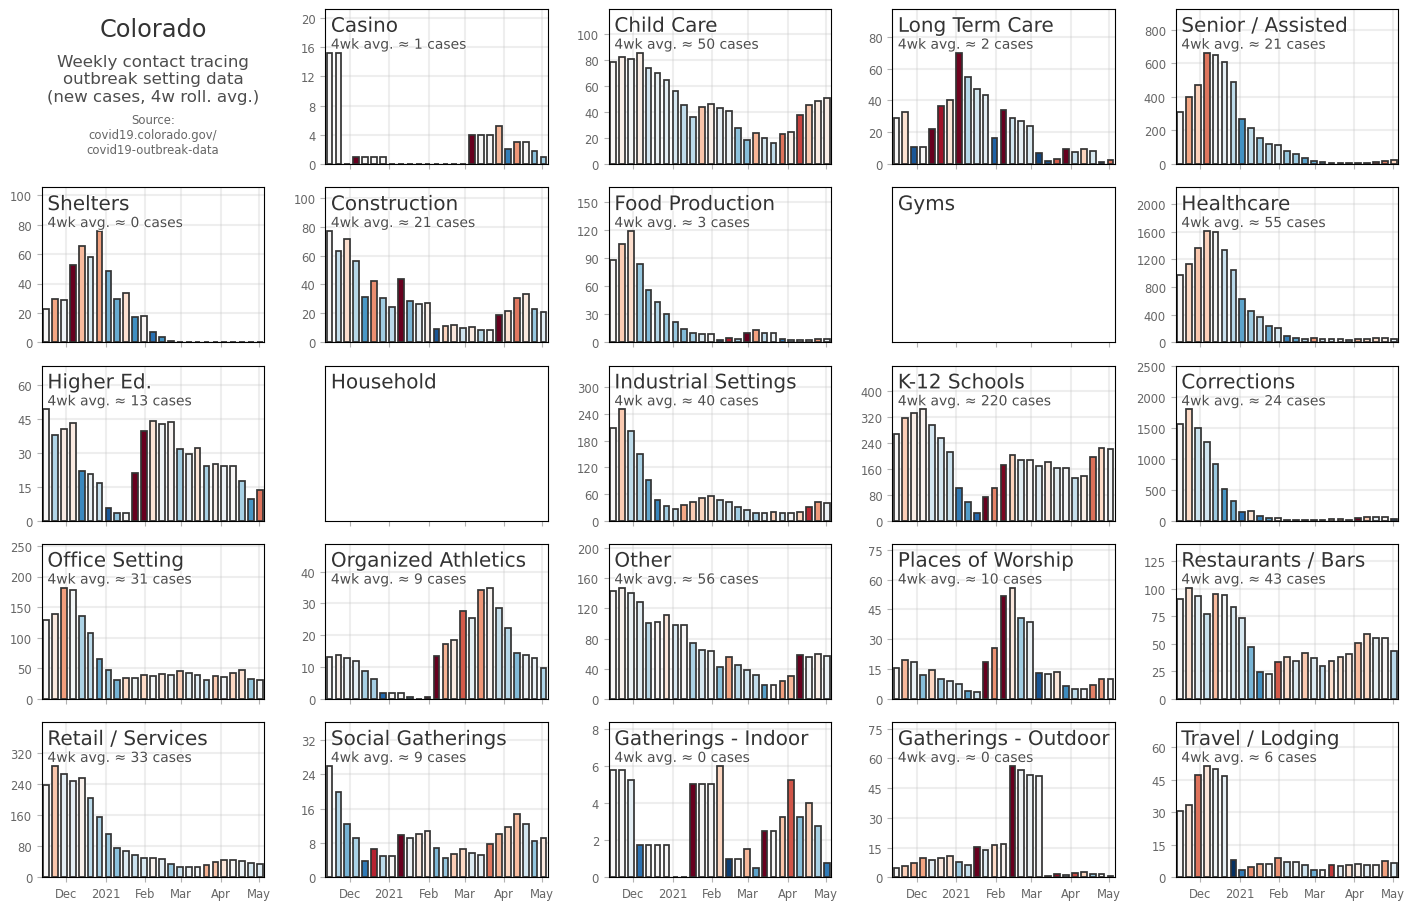

In [10]:
w = 3.5; h = 2.3
ncols = 5; nrows = 5

ymax_st = 650
colum = 'new_cases'
st_url = 'covid19.colorado.gov/\ncovid19-outbreak-data'
colim = 0.75

for samescale in ['diffscale']:#['samescale','diffscale']:

    tups = list(it.product(range(nrows), range(ncols)))
    fig, ax = plt.subplots(nrows, ncols, figsize=(ncols*w,nrows*h), dpi=100, sharex=True)#, sharey=True)
    plt.subplots_adjust(wspace=0.275,hspace=0.15)

    for di, dcurr in enumerate(sorted(outbreak_labs['setting'].unique())):

        di += 1
        aa = ax[tups[di]]
        if dcurr in df_plot['setting'].unique():
            cti = df_plot.loc[df_plot['setting']==dcurr].copy()
            cti = cti.loc[(cti['date']>'2020-10-18')&\
                          (cti['date']<=ll['date'].max())].sort_values('date').copy()

            cti[colum] = np.nan_to_num(cti[colum])
            norm = matplotlib.colors.Normalize(vmin=-colim, vmax=colim)
            cvals = norm(np.nan_to_num((cti[colum]+1).rolling(window=wid).mean().pct_change().values))
            col = plt.cm.RdBu_r(cvals)

            aa.bar([date_dict[i] for i in cti['date']], cti[colum].rolling(window=wid).mean(),
                   color=col, ec='.2', width=barw, lw=1.25)

            four_wmean = np.nanmean(np.nan_to_num(cti[colum].values)[-nw:])
            aa.text(0.025,0.815,'%iwk avg. ≈ %i %s'%(nw,four_wmean,colum.replace('new_','')),
                    ha='left', va='top',transform=aa.transAxes, fontsize='medium',color='.3',
                    path_effects=[path_effects.Stroke(linewidth=1.5, foreground='w'),
                                  path_effects.Normal()])

            aa.grid(linewidth=1.5,color='.75',alpha=0.25)
            aa.tick_params(labelcolor='.4',color='.7',labelsize='small')
            aa.set_xticks([date_dict[i] for i in dates_tt])
            aa.set_xticklabels(dates_ll)
            aa.set_xlim(date_dict['2020-10-18']-barw/2-1+wid*7,
                        date_dict[df_plot['date'].max()]+barw/2+1)

            aa.yaxis.set_major_locator(MaxNLocator(integer=True, nbins='auto'))
            ylims = aa.get_ylim()
            ydiff = ylims[1] - ylims[0]
            aa.set_ylim(ylims[0], ylims[1]+ydiff*0.325)

            if samescale=='samescale':
                aa.set_ylim(0, ymax_st)
            aa.text(0.025,0.95,labs[dcurr],ha='left',va='top',
                    transform=aa.transAxes,fontsize='x-large',color='.2',
                    path_effects=[path_effects.Stroke(linewidth=1.5, foreground='w'),
                                  path_effects.Normal()])
        else:
            aa.text(0.025,0.95,labs[dcurr],ha='left',va='top',
                    transform=aa.transAxes,fontsize='x-large',color='.2',
                    path_effects=[path_effects.Stroke(linewidth=1.5, foreground='w'),
                                  path_effects.Normal()])
            aa.tick_params(labelcolor='.4',color='.7',labelsize='small')
            aa.set_xticks([date_dict[i] for i in dates_tt])
            aa.set_yticks([])
            aa.set_xticklabels(dates_ll)
            aa.set_xlim(date_dict['2020-10-18']-barw/2-1+wid*7,
                        date_dict[df_plot['date'].max()]+barw/2+1)

    aa = ax[tups[0]]
    aa.text(0.5, 0.95, st_name, ha='center', va='top', transform=aa.transAxes,
            color='.2', fontsize='xx-large')
    aa.text(0.5, 0.55, 'Weekly contact tracing\noutbreak setting data\n(new cases, %sw roll. avg.)'%wid,
            ha='center', va='center', transform=aa.transAxes, color='.3', fontsize='large')
    aa.text(0.5, 0.05, 'Source:\n%s'%st_url,
            ha='center', va='bottom', transform=aa.transAxes, color='.4', fontsize='small')

    aa.set_axis_off()


    plt.savefig('../figs/pngs/%s_outbreak_settings_%s_%s.png'%(st_name,colum,samescale),
                dpi=425,bbox_inches='tight')

    plt.show()

___________

# Delaware

In [11]:
st_name = "Delaware"
de_data = client.open("COVID-data_%s"%st_name)
de_data_df = de_data.worksheet('schools')
de_dfg = pd.DataFrame(de_data_df.get_all_records(default_blank=np.nan))
de_dfg = de_dfg[['end_date', 'date', 'new_cases_students', 'new_cases_employee']].copy()

de_outb = de_data.worksheet('outbreaks')
de_outb = pd.DataFrame(de_outb.get_all_records(default_blank=np.nan))
de_outb = de_outb[['end_date','date','setting_raw','case_count']].copy()

de_dfg['case_count'] = de_dfg['new_cases_students'] + de_dfg['new_cases_employee']
tmp_sch = de_dfg[['end_date','date','case_count']].copy()
tmp_sch['setting_raw'] = 'School K-12'
tmp_sch = tmp_sch[['setting_raw','end_date','date','case_count']].copy()
tmp_sch['end_date'] = [DATERANGE[date_dict[i]+1] for i in tmp_sch['end_date']]
tmp_sch['date'] = [DATERANGE[date_dict[i]+1] for i in tmp_sch['date']]
de_outbg = pd.concat([de_outb,tmp_sch]).reset_index().iloc[:,1:]
de_outbg = de_outbg.rename(columns={'setting':'setting_raw','case_count':'new_cases'})

de_outbg = de_outbg.merge(outbreak_labs.loc[
                          (outbreak_labs['setting_raw'].isin(de_outbg['setting_raw'].unique()))&\
                          (outbreak_labs['source']==st_name)], how='left', on='setting_raw')
de_outbg = de_outbg.merge(DATE_DF[['date','week']], how='left', on='date')
de_outbg = de_outbg.groupby(['setting','date']).agg({'new_cases':'sum'}).reset_index()

In [12]:
df_plot = de_outbg.copy()

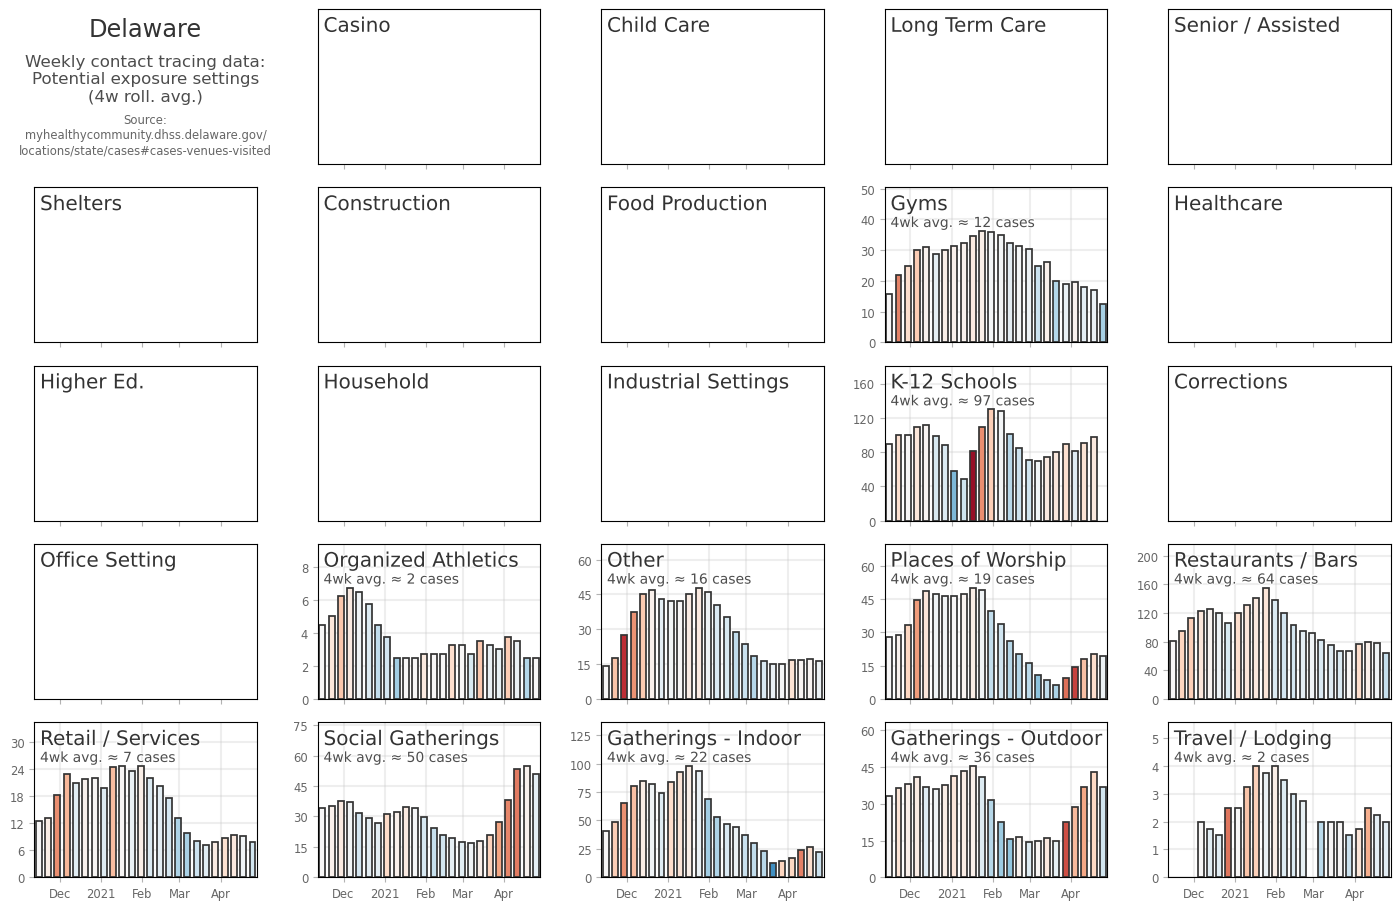

In [13]:
colum = 'new_cases'
w = 3.5; h = 2.3
ncols = 5; nrows = 5

ymax_st = 190
st_url = 'myhealthycommunity.dhss.delaware.gov/\nlocations/state/cases#cases-venues-visited'
colim = 0.75

for samescale in ['diffscale']:#['samescale','diffscale']:

    tups = list(it.product(range(nrows), range(ncols)))
    fig, ax = plt.subplots(nrows, ncols, figsize=(ncols*w,nrows*h), dpi=100, sharex=True)#, sharey=True)
    plt.subplots_adjust(wspace=0.275,hspace=0.15)

    for di, dcurr in enumerate(sorted(outbreak_labs['setting'].unique())):

        di += 1
        aa = ax[tups[di]]
        if dcurr in df_plot['setting'].unique():
            cti = df_plot.loc[df_plot['setting']==dcurr].copy()
            cti = cti.loc[(cti['date']>'2020-10-18')&\
                          (cti['date']<=ll['date'].max())].sort_values('date').copy()

            cti[colum] = np.nan_to_num(cti[colum])
            norm = matplotlib.colors.Normalize(vmin=-colim, vmax=colim)
            cvals = norm(np.nan_to_num((cti[colum]+1).rolling(window=wid).mean().pct_change().values))
            col = plt.cm.RdBu_r(cvals)

            aa.bar([date_dict[i] for i in cti['date']], cti[colum].rolling(window=wid).mean(),
                   color=col, ec='.2', width=barw, lw=1.25)

            four_wmean = np.nanmean(np.nan_to_num(cti[colum].values)[-nw:])
            aa.text(0.025,0.815,'%iwk avg. ≈ %i %s'%(nw,four_wmean,colum.replace('new_','')),
                    ha='left', va='top',transform=aa.transAxes, fontsize='medium',color='.3',
                    path_effects=[path_effects.Stroke(linewidth=1.5, foreground='w'),
                                  path_effects.Normal()])

            aa.grid(linewidth=1.5,color='.75',alpha=0.25)
            aa.tick_params(labelcolor='.4',color='.7',labelsize='small')
            aa.set_xticks([date_dict[i] for i in dates_tt])
            aa.set_xticklabels(dates_ll)
            aa.set_xlim(date_dict['2020-10-18']-barw/2-1+wid*7,
                        date_dict[df_plot['date'].max()]+barw/2+1)

            aa.yaxis.set_major_locator(MaxNLocator(integer=True, nbins='auto'))
            ylims = aa.get_ylim()
            ydiff = ylims[1] - ylims[0]
            aa.set_ylim(ylims[0], ylims[1]+ydiff*0.325)

            if samescale=='samescale':
                aa.set_ylim(0, ymax_st)
            aa.text(0.025,0.95,labs[dcurr],ha='left',va='top',
                    transform=aa.transAxes,fontsize='x-large',color='.2',
                    path_effects=[path_effects.Stroke(linewidth=1.5, foreground='w'),
                                  path_effects.Normal()])
        else:
            aa.text(0.025,0.95,labs[dcurr],ha='left',va='top',
                    transform=aa.transAxes,fontsize='x-large',color='.2',
                    path_effects=[path_effects.Stroke(linewidth=1.5, foreground='w'),
                                  path_effects.Normal()])
            aa.tick_params(labelcolor='.4',color='.7',labelsize='small')
            aa.set_xticks([date_dict[i] for i in dates_tt])
            aa.set_yticks([])
            aa.set_xticklabels(dates_ll)
            aa.set_xlim(date_dict['2020-10-18']-barw/2-1+wid*7,
                        date_dict[df_plot['date'].max()]+barw/2+1)

    aa = ax[tups[0]]
    aa.text(0.5, 0.95, st_name, ha='center', va='top', transform=aa.transAxes,
            color='.2', fontsize='xx-large')
    aa.text(0.5, 0.55, 'Weekly contact tracing data:\nPotential exposure settings\n(%sw roll. avg.)'%wid,
            ha='center', va='center', transform=aa.transAxes, color='.3', fontsize='large')
    aa.text(0.5, 0.05, 'Source:\n%s'%st_url,
            ha='center', va='bottom', transform=aa.transAxes, color='.4', fontsize='small')

    aa.set_axis_off()


    plt.savefig('../figs/pngs/%s_outbreak_settings_%s_%s.png'%(st_name,colum,samescale),
                dpi=425,bbox_inches='tight')

    plt.show()

_____________

# Illinois

In [14]:
st_name = "Illinois"
il_data = client.open("COVID-data_%s"%st_name)
il_data_df = il_data.worksheet('potential_outbreaks')
il_df = pd.DataFrame(il_data_df.get_all_records(default_blank=np.nan))
il_df['setting_raw'] = il_df['setting']
il_df['new_cases'] = il_df['cases']
il_df = il_df[['date','setting_raw','new_cases']].copy()
il_outbg = il_df.merge(outbreak_labs.loc[
                (outbreak_labs['setting_raw'].isin(il_df['setting_raw'].unique()))&\
                                            (outbreak_labs['source']==st_name)],
                          how='left', on='setting_raw')

il_outbg = il_outbg.merge(DATE_DF[['date','week']], how='left', on='date')
il_outbg = il_outbg.groupby(['setting','date']).agg({'new_cases':'sum'}).reset_index()

In [15]:
df_plot = il_outbg.copy()

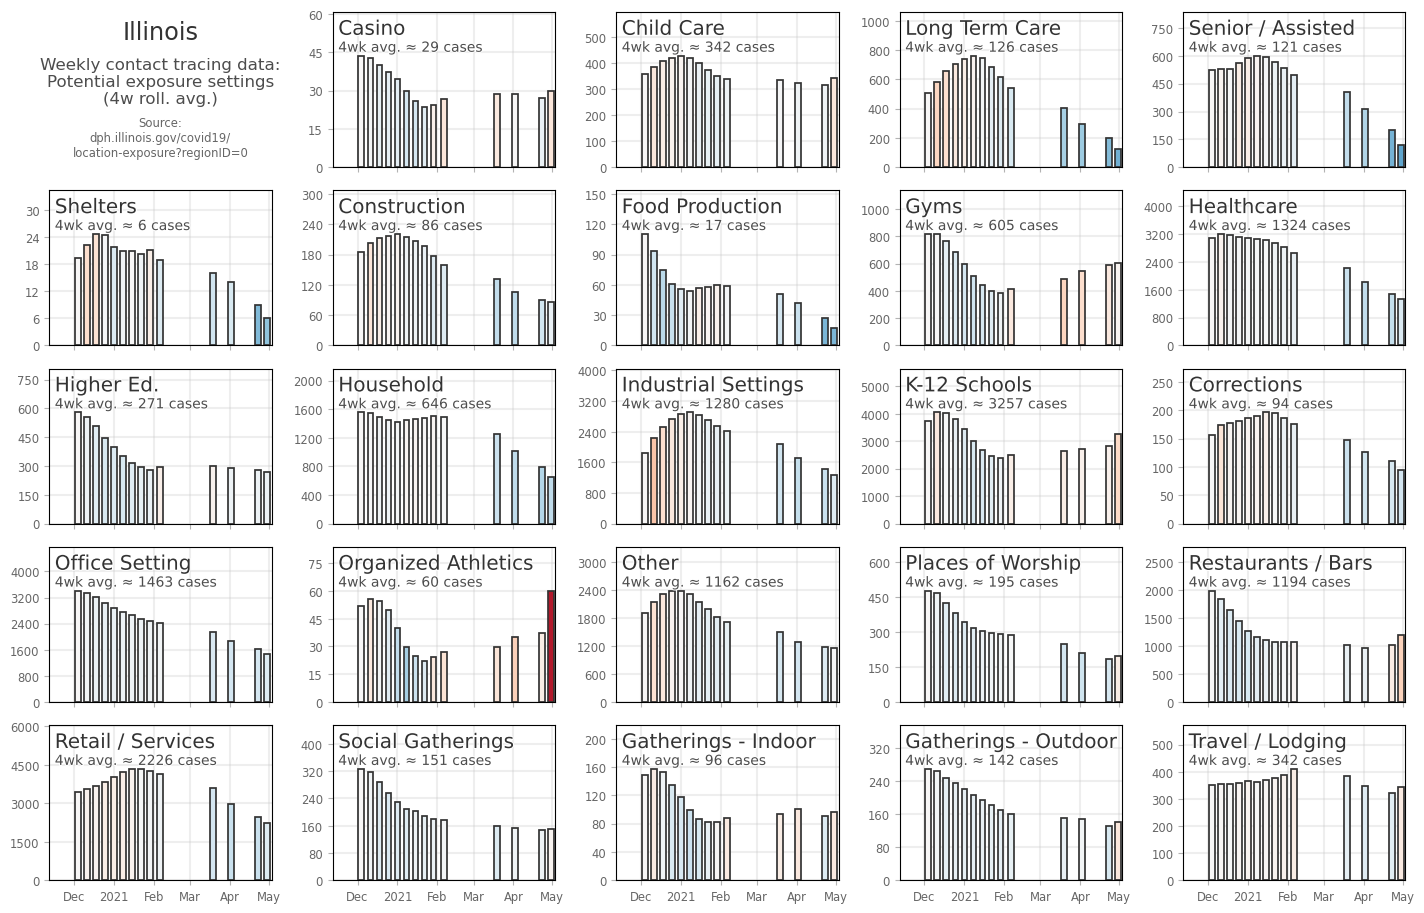

In [16]:
colum = 'new_cases'
w = 3.5; h = 2.3
ncols = 5; nrows = 5

ymax_st = 6190
st_url = 'dph.illinois.gov/covid19/\nlocation-exposure?regionID=0'
colim = 0.75

for samescale in ['diffscale']:#['samescale','diffscale']:

    tups = list(it.product(range(nrows), range(ncols)))
    fig, ax = plt.subplots(nrows, ncols, figsize=(ncols*w,nrows*h), dpi=100, sharex=True)#, sharey=True)
    plt.subplots_adjust(wspace=0.275,hspace=0.15)

    for di, dcurr in enumerate(sorted(outbreak_labs['setting'].unique())):

        di += 1
        aa = ax[tups[di]]
        if dcurr in df_plot['setting'].unique():
            cti = df_plot.loc[df_plot['setting']==dcurr].copy()
            cti = cti.loc[(cti['date']>'2020-10-18')&\
                          (cti['date']<=ll['date'].max())].sort_values('date').copy()

            cti[colum] = np.nan_to_num(cti[colum])
            norm = matplotlib.colors.Normalize(vmin=-colim, vmax=colim)
            cvals = norm(np.nan_to_num((cti[colum]+1).rolling(window=wid).mean().pct_change().values))
            col = plt.cm.RdBu_r(cvals)

            aa.bar([date_dict[i] for i in cti['date']], cti[colum].rolling(window=wid).mean(),
                   color=col, ec='.2', width=barw, lw=1.25)

            four_wmean = np.nanmean(np.nan_to_num(cti[colum].values)[-nw:])
            aa.text(0.025,0.815,'%iwk avg. ≈ %i %s'%(nw,four_wmean,colum.replace('new_','')),
                    ha='left', va='top',transform=aa.transAxes, fontsize='medium',color='.3',
                    path_effects=[path_effects.Stroke(linewidth=1.5, foreground='w'),
                                  path_effects.Normal()])

            aa.grid(linewidth=1.5,color='.75',alpha=0.25)
            aa.tick_params(labelcolor='.4',color='.7',labelsize='small')
            aa.set_xticks([date_dict[i] for i in dates_tt])
            aa.set_xticklabels(dates_ll)
            aa.set_xlim(date_dict['2020-10-18']-barw/2-1+wid*7,
                        date_dict[df_plot['date'].max()]+barw/2+1)

            aa.yaxis.set_major_locator(MaxNLocator(integer=True, nbins='auto'))
            ylims = aa.get_ylim()
            ydiff = ylims[1] - ylims[0]
            aa.set_ylim(ylims[0], ylims[1]+ydiff*0.325)

            if samescale=='samescale':
                aa.set_ylim(0, ymax_st)
            aa.text(0.025,0.95,labs[dcurr],ha='left',va='top',
                    transform=aa.transAxes,fontsize='x-large',color='.2',
                    path_effects=[path_effects.Stroke(linewidth=1.5, foreground='w'),
                                  path_effects.Normal()])
        else:
            aa.text(0.025,0.95,labs[dcurr],ha='left',va='top',
                    transform=aa.transAxes,fontsize='x-large',color='.2',
                    path_effects=[path_effects.Stroke(linewidth=1.5, foreground='w'),
                                  path_effects.Normal()])
            aa.tick_params(labelcolor='.4',color='.7',labelsize='small')
            aa.set_xticks([date_dict[i] for i in dates_tt])
            aa.set_yticks([])
            aa.set_xticklabels(dates_ll)
            aa.set_xlim(date_dict['2020-10-18']-barw/2-1+wid*7,
                        date_dict[df_plot['date'].max()]+barw/2+1)

    aa = ax[tups[0]]
    aa.text(0.5, 0.95, st_name, ha='center', va='top', transform=aa.transAxes,
            color='.2', fontsize='xx-large')
    aa.text(0.5, 0.55, 'Weekly contact tracing data:\nPotential exposure settings\n(%sw roll. avg.)'%wid,
            ha='center', va='center', transform=aa.transAxes, color='.3', fontsize='large')
    aa.text(0.5, 0.05, 'Source:\n%s'%st_url,
            ha='center', va='bottom', transform=aa.transAxes, color='.4', fontsize='small')

    aa.set_axis_off()


    plt.savefig('../figs/pngs/%s_outbreak_settings_%s_%s.png'%(st_name,colum,samescale),
                dpi=425,bbox_inches='tight')

    plt.show()

_________________

# Louisiana

In [17]:
st_name = "Louisiana"
la_data = client.open("COVID-data_%s"%st_name)
la_data_df = la_data.worksheet('outbreaks')
la_df = pd.DataFrame(la_data_df.get_all_records(default_blank=np.nan))
la_df = la_df[['date','setting','raw_new_cases']].copy()

la_data_df = la_data.worksheet('schools')
la_dfg = pd.DataFrame(la_data_df.get_all_records(default_blank=np.nan))
la_dfg['raw_new_cases'] = la_dfg['new_cases_employee'] + la_dfg['new_cases_students']
la_dfg = la_dfg.groupby('date').agg({'raw_new_cases':'sum'}).reset_index()
la_dfg['setting'] = 'Primary/Secondary School'

la_df = pd.concat([la_df, la_dfg]).reset_index().iloc[:,1:]

la_outbg = la_df.rename(columns={'setting':'setting_raw','raw_new_cases':'new_cases'})

la_outbg = la_outbg.merge(outbreak_labs.loc[
                          (outbreak_labs['setting_raw'].isin(la_outbg['setting_raw'].unique()))&\
                          (outbreak_labs['source']==st_name)], how='left', on='setting_raw')
la_outbg = la_outbg.merge(DATE_DF[['date','week']], how='left', on='date')
la_outbg = la_outbg.groupby(['setting','week']).agg({'new_cases':'sum','date':'min'}).reset_index()

In [18]:
df_plot = la_outbg.copy()

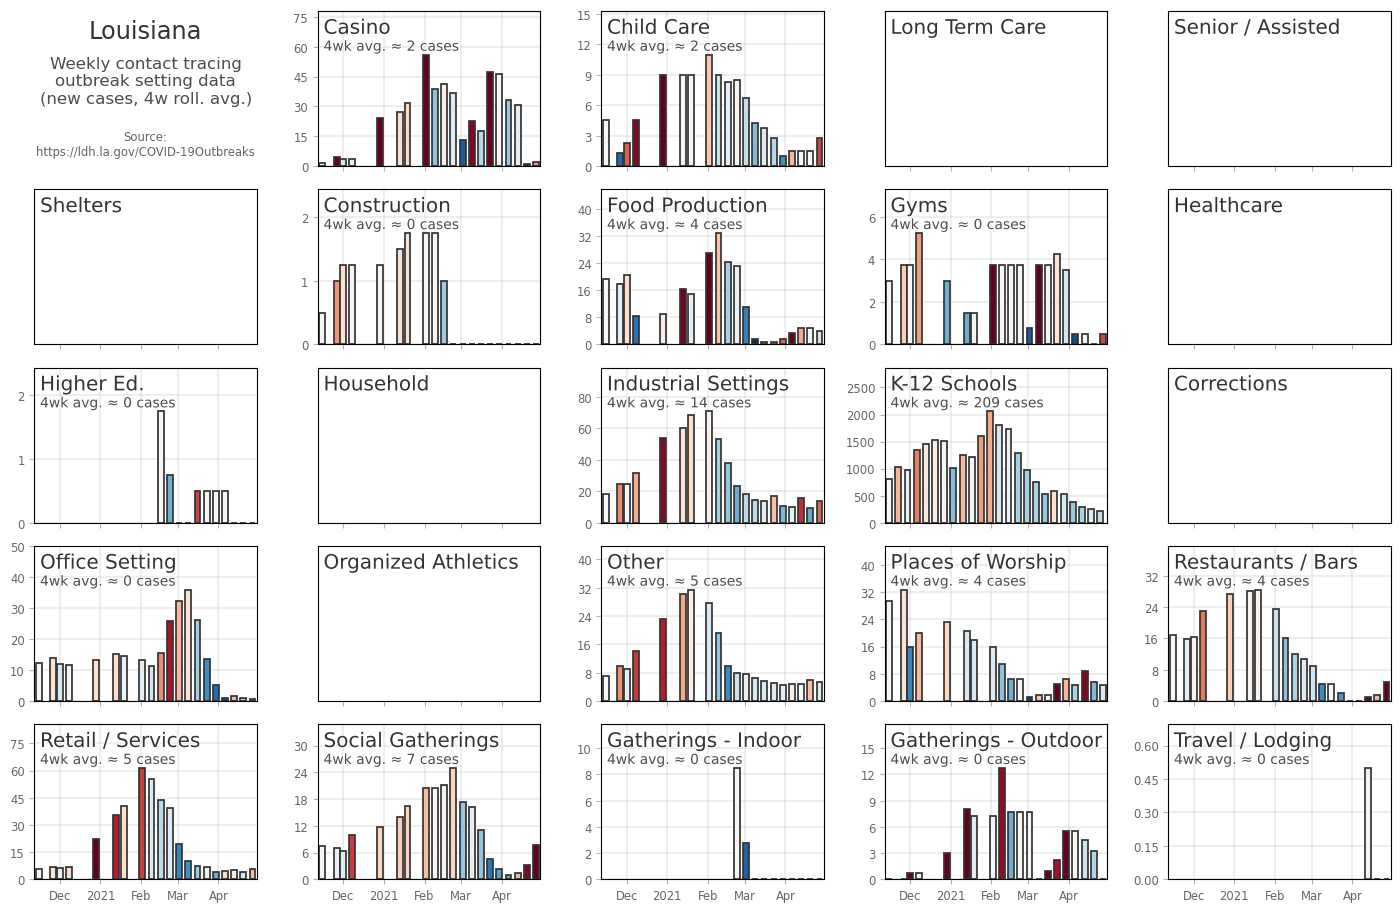

In [19]:
colum = 'new_cases'
w = 3.5; h = 2.3
ncols = 5; nrows = 5

ymax_st = 95
st_url = 'https://ldh.la.gov/COVID-19Outbreaks'
colim = 0.75

for samescale in ['diffscale']:#['samescale','diffscale']:

    tups = list(it.product(range(nrows), range(ncols)))
    fig, ax = plt.subplots(nrows, ncols, figsize=(ncols*w,nrows*h), dpi=100, sharex=True)#, sharey=True)
    plt.subplots_adjust(wspace=0.275,hspace=0.15)

    for di, dcurr in enumerate(sorted(outbreak_labs['setting'].unique())):

        di += 1
        aa = ax[tups[di]]
        if dcurr in df_plot['setting'].unique() and df_plot.loc[df_plot['setting']==dcurr][colum].sum()>0:
            cti = df_plot.loc[df_plot['setting']==dcurr].copy()
            cti = cti.loc[(cti['date']>'2020-10-18')&\
                          (cti['date']<=ll['date'].max())].sort_values('date').copy()

            cti[colum] = np.nan_to_num(cti[colum])
            norm = matplotlib.colors.Normalize(vmin=-colim, vmax=colim)
            cvals = norm(np.nan_to_num((cti[colum]+1).rolling(window=wid).mean().pct_change().values))
            col = plt.cm.RdBu_r(cvals)

            aa.bar([date_dict[i] for i in cti['date']], cti[colum].rolling(window=wid).mean(),
                   color=col, ec='.2', width=barw, lw=1.25)

            four_wmean = np.nanmean(np.nan_to_num(cti[colum].values)[-nw:])
            aa.text(0.025,0.815,'%iwk avg. ≈ %i %s'%(nw,four_wmean,colum.replace('new_','')),
                    ha='left', va='top',transform=aa.transAxes, fontsize='medium',color='.3',
                    path_effects=[path_effects.Stroke(linewidth=1.5, foreground='w'),
                                  path_effects.Normal()])

            aa.grid(linewidth=1.5,color='.75',alpha=0.25)
            aa.tick_params(labelcolor='.4',color='.7',labelsize='small')
            aa.set_xticks([date_dict[i] for i in dates_tt])
            aa.set_xticklabels(dates_ll)
            aa.set_xlim(date_dict['2020-10-18']-barw/2-1+wid*7,
                        date_dict[df_plot['date'].max()]+barw/2+1)

            aa.yaxis.set_major_locator(MaxNLocator(integer=True, nbins='auto'))
            ylims = aa.get_ylim()
            ydiff = ylims[1] - ylims[0]
            aa.set_ylim(ylims[0], ylims[1]+ydiff*0.325)

            if samescale=='samescale':
                aa.set_ylim(0, ymax_st)
                if dcurr == 'K-12 Schools':
                    aa.set_ylim(0, 2600)

            aa.text(0.025,0.95,labs[dcurr],ha='left',va='top',
                    transform=aa.transAxes,fontsize='x-large',color='.2',
                    path_effects=[path_effects.Stroke(linewidth=1.5, foreground='w'),
                                  path_effects.Normal()])
        else:
            aa.text(0.025,0.95,labs[dcurr],ha='left',va='top',
                    transform=aa.transAxes,fontsize='x-large',color='.2',
                    path_effects=[path_effects.Stroke(linewidth=1.5, foreground='w'),
                                  path_effects.Normal()])
            aa.tick_params(labelcolor='.4',color='.7',labelsize='small')
            aa.set_xticks([date_dict[i] for i in dates_tt])
            aa.set_yticks([])
            aa.set_xticklabels(dates_ll)
            aa.set_xlim(date_dict['2020-10-18']-barw/2-1+wid*7,
                        date_dict[df_plot['date'].max()]+barw/2+1)

    aa = ax[tups[0]]
    aa.text(0.5, 0.95, st_name, ha='center', va='top', transform=aa.transAxes,
            color='.2', fontsize='xx-large')
    aa.text(0.5, 0.55, 'Weekly contact tracing\noutbreak setting data\n(new cases, %iw roll. avg.)'%wid,
            ha='center', va='center', transform=aa.transAxes, color='.3', fontsize='large')
    aa.text(0.5, 0.05, 'Source:\n%s'%st_url,
            ha='center', va='bottom', transform=aa.transAxes, color='.4', fontsize='small')

    aa.set_axis_off()


    plt.savefig('../figs/pngs/%s_outbreak_settings_%s_%s.png'%(st_name,colum,samescale),
                dpi=425,bbox_inches='tight')

    plt.show()

______________

# Massachusetts

In [20]:
st_name = "Massachusetts"
ma_data = client.open("COVID-data_%s"%st_name)
ma_data_df = ma_data.worksheet('contact_tracing')
ma_df = pd.DataFrame(ma_data_df.get_all_records(default_blank=np.nan))
ma_df['date'] = ma_df['data_date']
ma_df = ma_df[['date','setting','raw_new_cases']].copy()
ma_outbg = ma_df.rename(columns={'setting':'setting_raw','raw_new_cases':'new_cases'})

ma_outbg = ma_outbg.merge(outbreak_labs.loc[
                          (outbreak_labs['setting_raw'].isin(ma_outbg['setting_raw'].unique()))&\
                          (outbreak_labs['source']==st_name)], how='left', on='setting_raw')
ma_outbg = ma_outbg.merge(DATE_DF[['date','week']], how='left', on='date')
ma_outbg = ma_outbg.groupby(['setting','week']).agg({'new_cases':'sum','date':'min'}).reset_index()

In [21]:
df_plot = ma_outbg.copy()

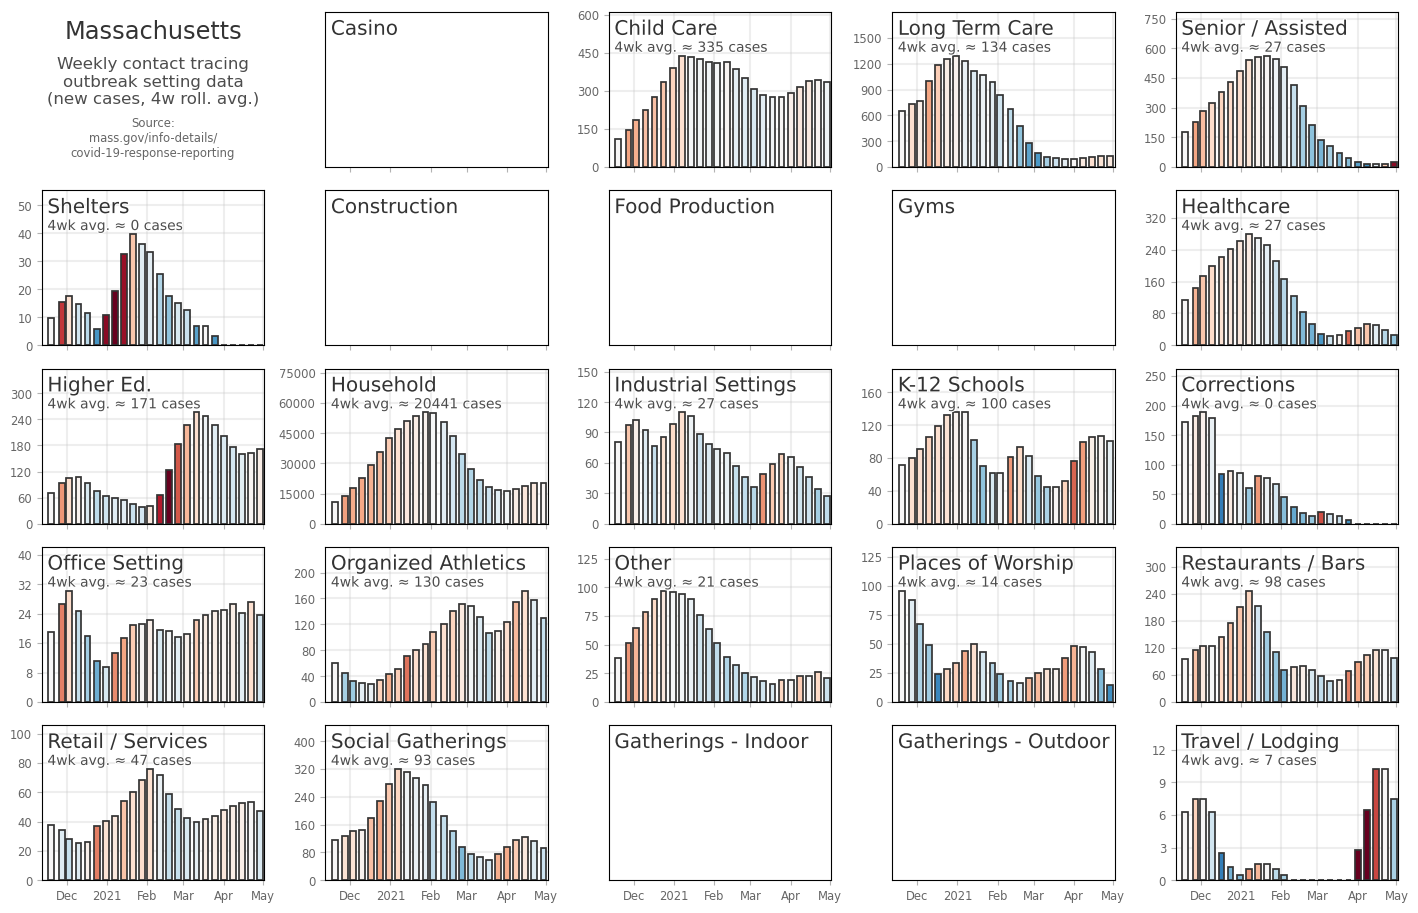

In [22]:
colum = 'new_cases'
w = 3.5; h = 2.3
ncols = 5; nrows = 5

ymax_st = 550
st_url = 'mass.gov/info-details/\ncovid-19-response-reporting'
colim = 0.75

for samescale in ['diffscale']:#['samescale','diffscale']:

    tups = list(it.product(range(nrows), range(ncols)))
    fig, ax = plt.subplots(nrows, ncols, figsize=(ncols*w,nrows*h), dpi=100, sharex=True)#, sharey=True)
    plt.subplots_adjust(wspace=0.275,hspace=0.15)

    for di, dcurr in enumerate(sorted(outbreak_labs['setting'].unique())):

        di += 1
        aa = ax[tups[di]]
        if dcurr in df_plot['setting'].unique() and df_plot.loc[df_plot['setting']==dcurr][colum].sum()>0:
            cti = df_plot.loc[df_plot['setting']==dcurr].copy()
            cti = cti.loc[(cti['date']>'2020-10-18')&\
                          (cti['date']<=ll['date'].max())].sort_values('date').copy()

            cti[colum] = np.nan_to_num(cti[colum])
            norm = matplotlib.colors.Normalize(vmin=-colim, vmax=colim)
            cvals = norm(np.nan_to_num((cti[colum]+1).rolling(window=wid).mean().pct_change().values))
            col = plt.cm.RdBu_r(cvals)

            aa.bar([date_dict[i] for i in cti['date']], cti[colum].rolling(window=wid).mean(),
                   color=col, ec='.2', width=barw, lw=1.25)

            four_wmean = np.nanmean(np.nan_to_num(cti[colum].values)[-nw:])
            aa.text(0.025,0.815,'%iwk avg. ≈ %i %s'%(nw,four_wmean,colum.replace('new_','')),
                    ha='left', va='top',transform=aa.transAxes, fontsize='medium',color='.3',
                    path_effects=[path_effects.Stroke(linewidth=1.5, foreground='w'),
                                  path_effects.Normal()])

            aa.grid(linewidth=1.5,color='.75',alpha=0.25)
            aa.tick_params(labelcolor='.4',color='.7',labelsize='small')
            aa.set_xticks([date_dict[i] for i in dates_tt])
            aa.set_xticklabels(dates_ll)
            aa.set_xlim(date_dict['2020-10-18']-barw/2-1+wid*7,
                        date_dict[df_plot['date'].max()]+barw/2+1)

            aa.yaxis.set_major_locator(MaxNLocator(integer=True, nbins='auto'))
            ylims = aa.get_ylim()
            ydiff = ylims[1] - ylims[0]
            aa.set_ylim(ylims[0], ylims[1]+ydiff*0.325)

            if samescale=='samescale':
                aa.set_ylim(0, ymax_st)
                if dcurr == 'Household':
                    aa.set_ylim(0, 60000)

            aa.text(0.025,0.95,labs[dcurr],ha='left',va='top',
                    transform=aa.transAxes,fontsize='x-large',color='.2',
                    path_effects=[path_effects.Stroke(linewidth=1.5, foreground='w'),
                                  path_effects.Normal()])
        else:
            aa.text(0.025,0.95,labs[dcurr],ha='left',va='top',
                    transform=aa.transAxes,fontsize='x-large',color='.2',
                    path_effects=[path_effects.Stroke(linewidth=1.5, foreground='w'),
                                  path_effects.Normal()])
            aa.tick_params(labelcolor='.4',color='.7',labelsize='small')
            aa.set_xticks([date_dict[i] for i in dates_tt])
            aa.set_yticks([])
            aa.set_xticklabels(dates_ll)
            aa.set_xlim(date_dict['2020-10-18']-barw/2-1+wid*7,
                        date_dict[df_plot['date'].max()]+barw/2+1)

    aa = ax[tups[0]]
    aa.text(0.5, 0.95, st_name, ha='center', va='top', transform=aa.transAxes,
            color='.2', fontsize='xx-large')
    aa.text(0.5, 0.55, 'Weekly contact tracing\noutbreak setting data\n(new cases, %iw roll. avg.)'%wid,
            ha='center', va='center', transform=aa.transAxes, color='.3', fontsize='large')
    aa.text(0.5, 0.05, 'Source:\n%s'%st_url,
            ha='center', va='bottom', transform=aa.transAxes, color='.4', fontsize='small')

    aa.set_axis_off()


    plt.savefig('../figs/pngs/%s_outbreak_settings_%s_%s.png'%(st_name,colum,samescale),
                dpi=425,bbox_inches='tight')

    plt.show()

_____________

# Michigan

In [23]:
st_name = "Michigan"
mi_data = client.open("COVID-data_%s"%st_name)
mi_data_df = mi_data.worksheet('outbreaks')
mi_df = pd.DataFrame(mi_data_df.get_all_records(default_blank=np.nan))
mi_df = mi_df[['date','setting_raw','cases_new_ongoing']].copy()
mi_outbg = mi_df.rename(columns={'setting':'setting_raw','cases_new_ongoing':'new_cases'})

mi_outbg = mi_outbg.merge(outbreak_labs.loc[
                          (outbreak_labs['setting_raw'].isin(mi_outbg['setting_raw'].unique()))&\
                          (outbreak_labs['source']==st_name)], how='left', on='setting_raw')
mi_outbg = mi_outbg.merge(DATE_DF[['date','week']], how='left', on='date')
mi_outbg = mi_outbg.groupby(['setting','week']).agg({'new_cases':'sum','date':'min'}).reset_index()

In [24]:
df_plot = mi_outbg.copy()

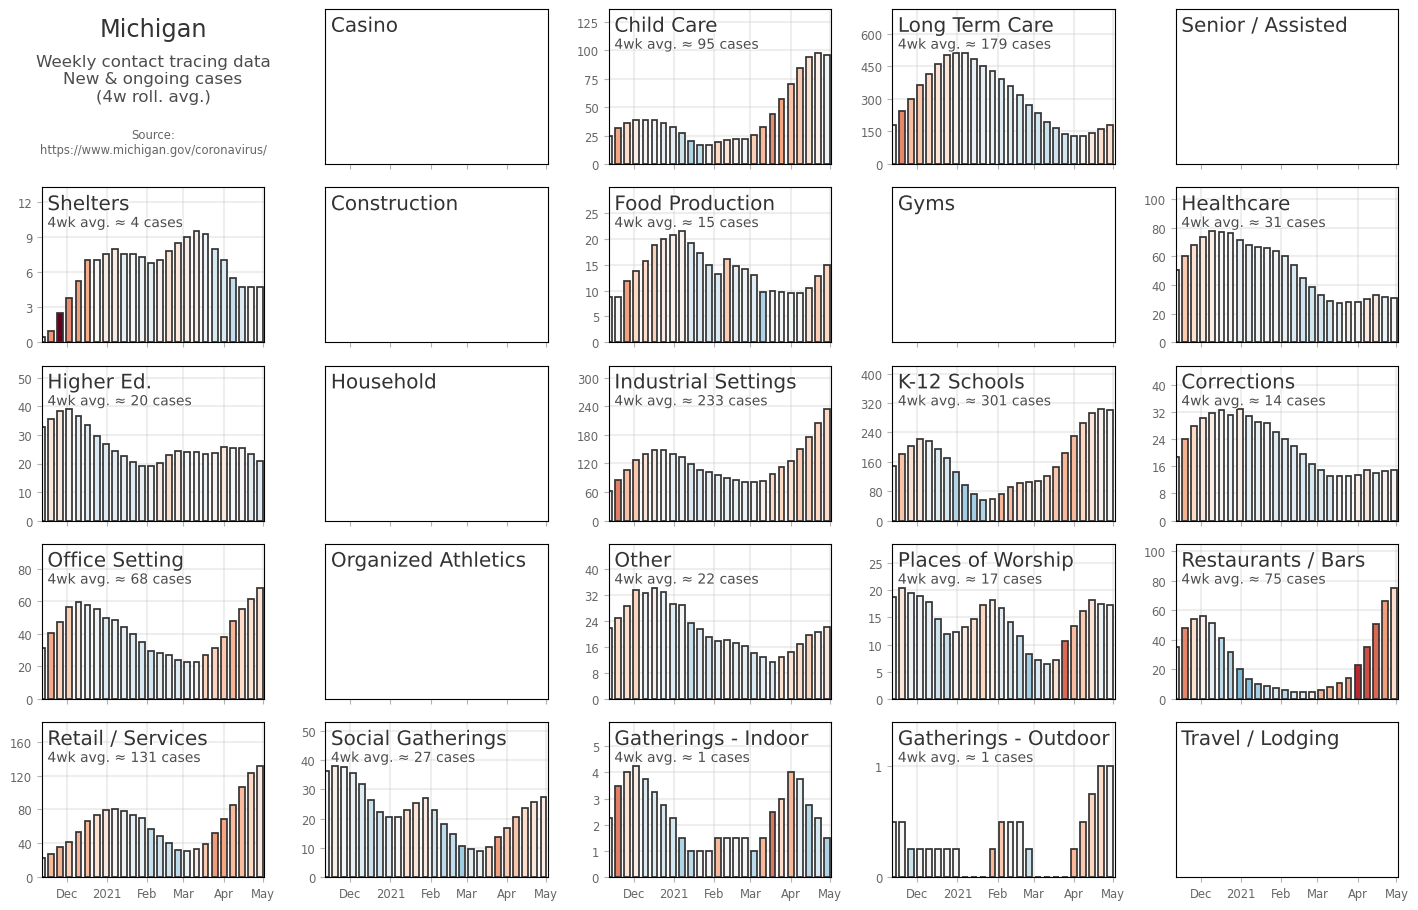

In [25]:
colum = 'new_cases'
w = 3.5; h = 2.3
ncols = 5; nrows = 5

ymax_st = 390
st_url = 'https://www.michigan.gov/coronavirus/'
colim = 0.75

for samescale in ['diffscale']:#['samescale','diffscale']:

    tups = list(it.product(range(nrows), range(ncols)))
    fig, ax = plt.subplots(nrows, ncols, figsize=(ncols*w,nrows*h), dpi=100, sharex=True)#, sharey=True)
    plt.subplots_adjust(wspace=0.275,hspace=0.15)

    for di, dcurr in enumerate(sorted(outbreak_labs['setting'].unique())):

        di += 1
        aa = ax[tups[di]]
        if dcurr in df_plot['setting'].unique() and df_plot.loc[df_plot['setting']==dcurr][colum].sum()>0:
            cti = df_plot.loc[df_plot['setting']==dcurr].copy()
            cti = cti.loc[(cti['date']>'2020-10-18')&\
                          (cti['date']<=ll['date'].max())].sort_values('date').copy()

            cti[colum] = np.nan_to_num(cti[colum])
            norm = matplotlib.colors.Normalize(vmin=-colim, vmax=colim)
            cvals = norm(np.nan_to_num((cti[colum]+1).rolling(window=wid).mean().pct_change().values))
            col = plt.cm.RdBu_r(cvals)

            aa.bar([date_dict[i] for i in cti['date']], cti[colum].rolling(window=wid).mean(),
                   color=col, ec='.2', width=barw, lw=1.25)

            four_wmean = np.nanmean(np.nan_to_num(cti[colum].values)[-nw:])
            aa.text(0.025,0.815,'%iwk avg. ≈ %i %s'%(nw,four_wmean,colum.replace('new_','')),
                    ha='left', va='top',transform=aa.transAxes, fontsize='medium',color='.3',
                    path_effects=[path_effects.Stroke(linewidth=1.5, foreground='w'),
                                  path_effects.Normal()])

            aa.grid(linewidth=1.5,color='.75',alpha=0.25)
            aa.tick_params(labelcolor='.4',color='.7',labelsize='small')
            aa.set_xticks([date_dict[i] for i in dates_tt])
            aa.set_xticklabels(dates_ll)
            aa.set_xlim(date_dict['2020-10-18']-barw/2-1+wid*7,
                        date_dict[df_plot['date'].max()]+barw/2+1)

            aa.yaxis.set_major_locator(MaxNLocator(integer=True, nbins='auto'))
            ylims = aa.get_ylim()
            ydiff = ylims[1] - ylims[0]
            aa.set_ylim(ylims[0], ylims[1]+ydiff*0.325)

            if samescale=='samescale':
                aa.set_ylim(0, ymax_st)
                if dcurr == 'Household':
                    aa.set_ylim(0, 60000)

            aa.text(0.025,0.95,labs[dcurr],ha='left',va='top',
                    transform=aa.transAxes,fontsize='x-large',color='.2',
                    path_effects=[path_effects.Stroke(linewidth=1.5, foreground='w'),
                                  path_effects.Normal()])
        else:
            aa.text(0.025,0.95,labs[dcurr],ha='left',va='top',
                    transform=aa.transAxes,fontsize='x-large',color='.2',
                    path_effects=[path_effects.Stroke(linewidth=1.5, foreground='w'),
                                  path_effects.Normal()])
            aa.tick_params(labelcolor='.4',color='.7',labelsize='small')
            aa.set_xticks([date_dict[i] for i in dates_tt])
            aa.set_yticks([])
            aa.set_xticklabels(dates_ll)
            aa.set_xlim(date_dict['2020-10-18']-barw/2-1+wid*7,
                        date_dict[df_plot['date'].max()]+barw/2+1)

    aa = ax[tups[0]]
    aa.text(0.5, 0.95, st_name, ha='center', va='top', transform=aa.transAxes,
            color='.2', fontsize='xx-large')
    aa.text(0.5, 0.55, 'Weekly contact tracing data\nNew & ongoing cases\n(%iw roll. avg.)'%wid,
            ha='center', va='center', transform=aa.transAxes, color='.3', fontsize='large')
    aa.text(0.5, 0.05, 'Source:\n%s'%st_url,
            ha='center', va='bottom', transform=aa.transAxes, color='.4', fontsize='small')

    aa.set_axis_off()


    plt.savefig('../figs/pngs/%s_outbreak_settings_%s_%s.png'%(st_name,colum,samescale),
                dpi=425,bbox_inches='tight')

    plt.show()

______________

# Washington

In [60]:
st_name = "Washington"
wa_data = client.open("COVID-data_%s"%st_name)
wa_data_df = wa_data.worksheet('outbreaks')
wa_df = pd.DataFrame(wa_data_df.get_all_records(default_blank=np.nan))
wa_df = wa_df[['date','setting_raw','total_clusters','new_clusters']].copy()
wa_outbg = wa_df.rename(columns={'setting':'setting_raw','cases_new_ongoing':'new_cases'})

wa_outbg = wa_outbg.merge(outbreak_labs.loc[
                          (outbreak_labs['setting_raw'].isin(wa_outbg['setting_raw'].unique()))&\
                          (outbreak_labs['source']==st_name)], how='left', on='setting_raw')
wa_outbg = wa_outbg.merge(DATE_DF[['date','week']], how='left', on='date')
wa_outbg = wa_outbg.groupby(['setting','week']).agg({'new_clusters':'sum','date':'min'}).reset_index()

In [61]:
df_plot = wa_outbg.copy()

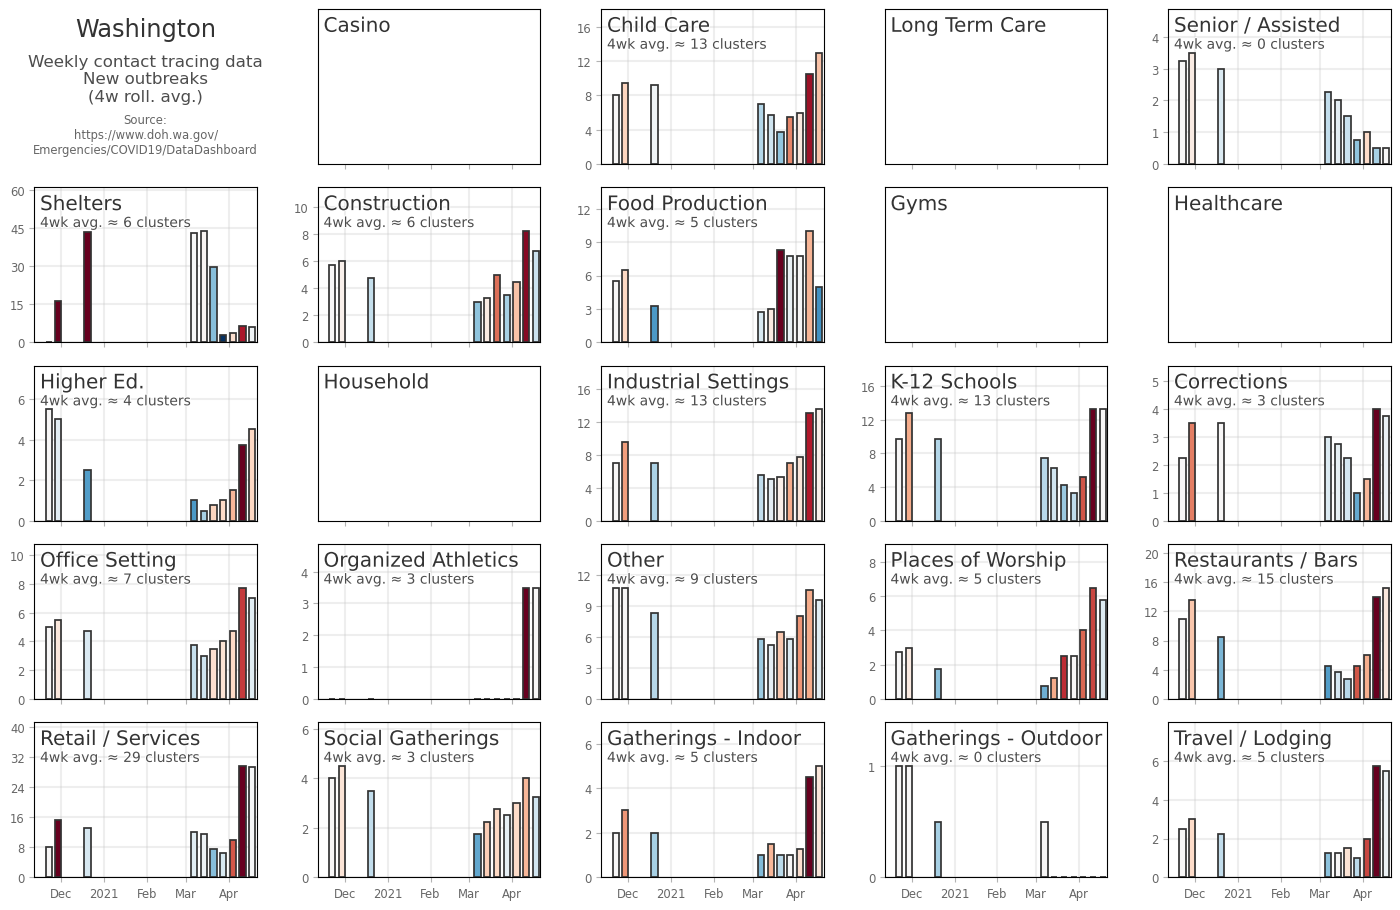

In [64]:
colum = 'new_clusters'
w = 3.5; h = 2.3
ncols = 5; nrows = 5

ymax_st = 390
st_url = 'https://www.doh.wa.gov/\nEmergencies/COVID19/DataDashboard'
colim = 0.75

for samescale in ['diffscale']:#['samescale','diffscale']:

    tups = list(it.product(range(nrows), range(ncols)))
    fig, ax = plt.subplots(nrows, ncols, figsize=(ncols*w,nrows*h), dpi=100, sharex=True)#, sharey=True)
    plt.subplots_adjust(wspace=0.275,hspace=0.15)

    for di, dcurr in enumerate(sorted(outbreak_labs['setting'].unique())):

        di += 1
        aa = ax[tups[di]]
        if dcurr in df_plot['setting'].unique() and df_plot.loc[df_plot['setting']==dcurr][colum].sum()>0:
            cti = df_plot.loc[df_plot['setting']==dcurr].copy()
            cti = cti.loc[(cti['date']>'2020-10-18')&\
                          (cti['date']<=ll['date'].max())].sort_values('date').copy()

            cti[colum] = np.nan_to_num(cti[colum])
            norm = matplotlib.colors.Normalize(vmin=-colim, vmax=colim)
            cvals = norm(np.nan_to_num((cti[colum]+1).rolling(window=wid).mean().pct_change().values))
            col = plt.cm.RdBu_r(cvals)

            aa.bar([date_dict[i] for i in cti['date']], cti[colum].rolling(window=wid).mean(),
                   color=col, ec='.2', width=barw, lw=1.25)

            four_wmean = np.nanmean(np.nan_to_num(cti[colum].values)[-nw:])
            aa.text(0.025,0.815,'%iwk avg. ≈ %i %s'%(nw,four_wmean,colum.replace('new_','')),
                    ha='left', va='top',transform=aa.transAxes, fontsize='medium',color='.3',
                    path_effects=[path_effects.Stroke(linewidth=1.5, foreground='w'),
                                  path_effects.Normal()])

            aa.grid(linewidth=1.5,color='.75',alpha=0.25)
            aa.tick_params(labelcolor='.4',color='.7',labelsize='small')
            aa.set_xticks([date_dict[i] for i in dates_tt])
            aa.set_xticklabels(dates_ll)
            aa.set_xlim(date_dict['2020-10-18']-barw/2-1+wid*7,
                        date_dict[df_plot['date'].max()]+barw/2+1)

            aa.yaxis.set_major_locator(MaxNLocator(integer=True, nbins='auto'))
            ylims = aa.get_ylim()
            ydiff = ylims[1] - ylims[0]
            aa.set_ylim(ylims[0], ylims[1]+ydiff*0.325)

            if samescale=='samescale':
                aa.set_ylim(0, ymax_st)
                if dcurr == 'Household':
                    aa.set_ylim(0, 60000)

            aa.text(0.025,0.95,labs[dcurr],ha='left',va='top',
                    transform=aa.transAxes,fontsize='x-large',color='.2',
                    path_effects=[path_effects.Stroke(linewidth=1.5, foreground='w'),
                                  path_effects.Normal()])
        else:
            aa.text(0.025,0.95,labs[dcurr],ha='left',va='top',
                    transform=aa.transAxes,fontsize='x-large',color='.2',
                    path_effects=[path_effects.Stroke(linewidth=1.5, foreground='w'),
                                  path_effects.Normal()])
            aa.tick_params(labelcolor='.4',color='.7',labelsize='small')
            aa.set_xticks([date_dict[i] for i in dates_tt])
            aa.set_yticks([])
            aa.set_xticklabels(dates_ll)
            aa.set_xlim(date_dict['2020-10-18']-barw/2-1+wid*7,
                        date_dict[df_plot['date'].max()]+barw/2+1)

    aa = ax[tups[0]]
    aa.text(0.5, 0.95, st_name, ha='center', va='top', transform=aa.transAxes,
            color='.2', fontsize='xx-large')
    aa.text(0.5, 0.55, 'Weekly contact tracing data\nNew outbreaks\n(%iw roll. avg.)'%wid,
            ha='center', va='center', transform=aa.transAxes, color='.3', fontsize='large')
    aa.text(0.5, 0.05, 'Source:\n%s'%st_url,
            ha='center', va='bottom', transform=aa.transAxes, color='.4', fontsize='small')

    aa.set_axis_off()


    plt.savefig('../figs/pngs/%s_outbreak_settings_%s_%s.png'%(st_name,colum,samescale),
                dpi=425,bbox_inches='tight')

    plt.show()

# Cases per cluster

In [32]:
st_name = "Kansas"
ks_data = client.open("COVID-data_%s"%st_name)
ks_data_df = ks_data.worksheet('outbreaks')
ks_df = pd.DataFrame(ks_data_df.get_all_records(default_blank=np.nan))
ks_df = ks_df.loc[ks_df['date']==ks_df['date'].max()][['date','setting',
                                                       'total_clusters','total_cases']].copy()
ks_outbg = ks_df.rename(columns={'setting':'setting_raw','raw_new_cases':'new_cases'})
ks_outbg = ks_outbg.merge(outbreak_labs.loc[
                          (outbreak_labs['setting_raw'].isin(ks_outbg['setting_raw'].unique()))&\
                          (outbreak_labs['source']==st_name)], how='left', on='setting_raw')


ks_outbg = ks_outbg.merge(DATE_DF[['date','week']], how='left', on='date')
ks_outbg = ks_outbg.groupby(['setting','week']).agg({'total_cases':'sum',
                                                     'total_clusters':'sum',
                                                     'date':'min'}).reset_index()
ks_outbg['cases_per_cluster'] = ks_outbg['total_cases']/ks_outbg['total_clusters']
ks_outbg = ks_outbg[['date','setting', 'cases_per_cluster']].copy()
ks_outbg['state'] = st_name
ks_outbg = ks_outbg[['setting','cases_per_cluster','state']].copy()

In [33]:
st_name = 'Colorado'
co_data = client.open("COVID-data_%s"%st_name)
co_df = co_data.worksheet('outbreaks')
co_df = pd.DataFrame(co_df.get_all_records(default_blank=np.nan))
co_df = co_df.rename(columns={'setting':'setting_raw'})
co_df = co_df.merge(outbreak_labs.loc[(outbreak_labs['setting_raw'].isin(co_df['setting_raw'].unique()))&\
                   (outbreak_labs['source']==st_name)])
co_df['new_cases'] = co_df['new_cases'].astype(float)
co_df['new_deaths'] = co_df['new_deaths'].astype(float)
co_df = co_df.merge(DATE_DF[['date','week']], how='left', on='date')

co_outbg = co_df.groupby('setting').agg({'new_cases':'sum','name':'count'}).reset_index()
co_outbg = co_outbg.rename(columns={'name':'new_clusters'})
co_outbg['cases_per_cluster'] = co_outbg['new_cases']/co_outbg['new_clusters']
co_outbg['state'] = st_name
co_outbg = co_outbg[['setting','cases_per_cluster','state']].copy()

In [34]:
st_name = "Louisiana"
la_data = client.open("COVID-data_%s"%st_name)
la_data_df = la_data.worksheet('outbreaks')
la_df = pd.DataFrame(la_data_df.get_all_records(default_blank=np.nan))
la_outbg = la_df.groupby('setting').agg({'raw_total_clusters':'max','raw_total_cases':'max'}).reset_index()
la_outbg = la_outbg.rename(columns={'setting':'setting_raw'})
la_outbg = la_outbg.merge(outbreak_labs.loc[
                          (outbreak_labs['setting_raw'].isin(la_outbg['setting_raw'].unique()))&\
                          (outbreak_labs['source']==st_name)], how='left', on='setting_raw')

la_outbg = la_outbg.groupby('setting').agg({'raw_total_cases':'sum',
                                            'raw_total_clusters':'sum'}).reset_index()
la_outbg['cases_per_cluster'] = la_outbg['raw_total_cases']/la_outbg['raw_total_clusters']
la_outbg['state'] = st_name
la_outbg = la_outbg[['setting','cases_per_cluster','state']].copy()

In [35]:
st_name = "Massachusetts"
ma_data = client.open("COVID-data_%s"%st_name)
ma_data_df = ma_data.worksheet('contact_tracing')
ma_df = pd.DataFrame(ma_data_df.get_all_records(default_blank=np.nan))
ma_outbg = ma_df.groupby('setting').agg({'raw_new_clusters':'sum','raw_new_cases':'sum'}).reset_index()
ma_outbg = ma_outbg.rename(columns={'setting':'setting_raw'})
ma_outbg = ma_outbg.merge(outbreak_labs.loc[
                          (outbreak_labs['setting_raw'].isin(ma_outbg['setting_raw'].unique()))&\
                          (outbreak_labs['source']==st_name)], how='left', on='setting_raw')

ma_outbg = ma_outbg.groupby('setting').agg({'raw_new_cases':'sum',
                                            'raw_new_clusters':'sum'}).reset_index()
ma_outbg['cases_per_cluster'] = ma_outbg['raw_new_cases']/ma_outbg['raw_new_clusters']
ma_outbg['state'] = st_name
ma_outbg = ma_outbg[['setting','cases_per_cluster','state']].copy()

In [36]:
outb_df = pd.concat([co_outbg,ks_outbg,la_outbg,ma_outbg]).reset_index().iloc[:,1:]

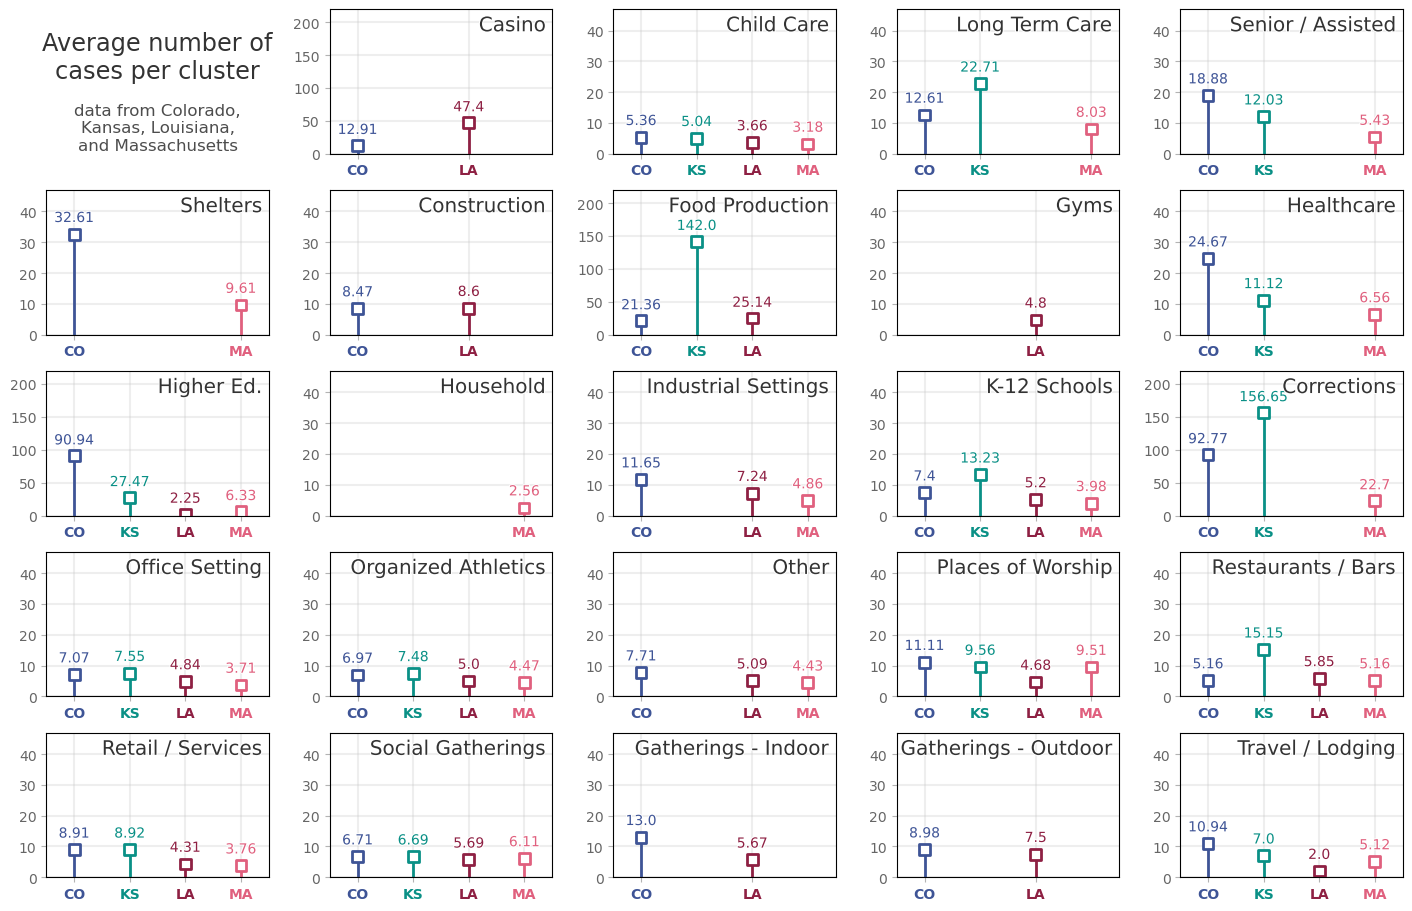

In [37]:
colum = 'cases_per_cluster'
w = 3.5; h = 2.3
ncols = 5; nrows = 5
xvs = dict(zip(outb_df['state'].unique(),list(range(outb_df['state'].nunique()))))
xvslabs = dict(zip(outb_df['state'].unique(),['CO','KS','LA','MA']))
cols = dict(zip(outb_df['state'].unique(),['#3E5496','#0A9086','#8E2043','#E0607E']))


ymax_st1 = 47
ymax_st2 = 220

tups = list(it.product(range(nrows), range(ncols)))
fig, ax = plt.subplots(nrows, ncols, figsize=(ncols*w,nrows*h), dpi=100)
plt.subplots_adjust(wspace=0.275,hspace=0.25)

for di, dcurr in enumerate(sorted(outb_df['setting'].unique())):

    di += 1
    aa = ax[tups[di]]
    cti = outb_df.loc[outb_df['setting']==dcurr].copy()

    cti[colum] = np.nan_to_num(cti[colum])

    aa.vlines([xvs[i] for i in cti['state']], 0, cti[colum].values,
               lw=2, zorder=1,color=[cols[i] for i in cti['state']])
    aa.scatter([xvs[i] for i in cti['state']], cti[colum].values,
               c='w', ec=[cols[i] for i in cti['state']], marker='s', lw=2, s=60,zorder=2)

    aa.grid(linewidth=1.5,color='.75',alpha=0.25)
    aa.tick_params(labelcolor='.4',color='.7')
    aa.set_xticks([xvs[i] for i in cti['state'].values])
    aa.set_xticklabels([xvslabs[i] for i in cti['state'].values],fontweight='bold')
    for xti,xtick in enumerate(aa.get_xticklabels()):
        xtick.set_color(cols[cti['state'].values[xti]])
    
    aa.yaxis.set_major_locator(MaxNLocator(integer=True, nbins='auto'))
    ylims = aa.get_ylim()
    ydiff = ylims[1] - ylims[0]
    aa.set_ylim(0, ylims[1]+ydiff*0.325)
    aa.set_xlim(-0.5, len(xvs)-0.5)

    pady = 3
    if dcurr in ['Law Enforcement / Corrections','Higher Education','Food Production','Casino']:
        pady = 3*ymax_st2/ymax_st1
        pady = pady * 0.9

    for xi,x in enumerate(cti[colum].values.round(2)):
        aa.text(xvs[cti['state'].values[xi]],x+pady, x, ha='center',va='bottom',
                color=cols[cti['state'].values[xi]],
                path_effects=[path_effects.Stroke(linewidth=1.5, foreground='w'),
                              path_effects.Normal()])


    aa.set_ylim(0, ymax_st1)
    if dcurr in ['Law Enforcement / Corrections','Higher Education','Food Production','Casino']:
        aa.set_ylim(0, ymax_st2)

    aa.text(0.9725,0.95,labs[dcurr],ha='right',va='top',
            transform=aa.transAxes,fontsize='x-large',color='.2',
            path_effects=[path_effects.Stroke(linewidth=1.5, foreground='w'),
                          path_effects.Normal()])

aa = ax[tups[0]]
aa.text(0.5, 0.85, 'Average number of\ncases per cluster', ha='center', va='top', transform=aa.transAxes,
        color='.2', fontsize='xx-large')
aa.text(0.5, 0.35, 'data from Colorado,\nKansas, Louisiana,\nand Massachusetts',
        ha='center', va='top', transform=aa.transAxes, color='.3', fontsize='large')

aa.set_axis_off()


plt.savefig('../figs/pngs/outbreak_settings_cases_per_cluster.png',
            dpi=425,bbox_inches='tight')

plt.show()

____________________________________